**Definizione problema**
* Griglia di dimensione NxN
* M oggetti posizionati nella griglia, ogni oggetto ha un peso. Superato una certa soglia, il giocatore impiega più tempo a compiere un turno (e.g. sopra 50 kg, per eseguire uno step impiega due turni)
* A partire da una starting position, l'aggente deve raccogliere gli oggetti minimizzando il numero di passi
* Nella mappa ci possono essere ostacoli

In [6]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Dimensione della griglia
grid_size = (10, 10)
starting_position = (0, 0)

# Posizioni degli oggetti
objects = [(1, 2), (4, 5), (7, 8), (2, 3)]
weights = [0, 0, 0, 0]  # Esempio di pesi

# Posizioni degli ostacoli
obstacles = [(3, 3), (3, 4), (3, 5), (5, 5), (5, 6), (5, 7)]

# Numero di elementi da raccogliere (predefinito dalle posizioni)
num_elements = len(objects)
    

In [7]:
# Creazione del grafo della griglia con ostacoli
def create_grid_graph(grid_size, obstacles):
    G = nx.grid_2d_graph(grid_size[0], grid_size[1])
    for obstacle in obstacles:
        if G.has_node(obstacle):
            G.remove_node(obstacle)
    return G

G = create_grid_graph(grid_size, obstacles)

# Funzione per calcolare la distanza di Manhattan con A*
def a_star_distance(G, start, goal):
    try:
        path = nx.astar_path(G, start, goal, heuristic=lambda a, b: abs(a[0] - b[0]) + abs(a[1] - b[1]))
        return len(path) - 1  # La lunghezza del percorso meno 1 per contare i passi
    except nx.NetworkXNoPath:
        return float('inf')

In [8]:
# Funzione per calcolare la lunghezza del percorso
def evaluate(individual, positions, weights, G, weight_limit=5):
    distance = a_star_distance(G, starting_position, positions[individual[0]])
    total_weight = weights[individual[0]]
    
    for i in range(0, len(individual) - 1):
        if total_weight > weight_limit:
            distance += 2 * a_star_distance(G, positions[individual[i]], positions[individual[i + 1]])
        else:
            distance += a_star_distance(G, positions[individual[i]], positions[individual[i + 1]])
        total_weight += weights[individual[i + 1]]
    
    return distance,

In [9]:
# Definizione del tipo di problema e fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Registrazione delle funzioni genetiche
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(num_elements), num_elements) # Permutazione casuale degli indici
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Funzioni di crossover e mutazione
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.02)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate, positions=objects, weights=weights, G=G)

# Parametri dell'algoritmo genetico
population_size = 10
num_generations = 500
cxpb, mutpb = 0.7, 0.2

# Creazione della popolazione iniziale
population = toolbox.population(n=population_size)

# Algoritmo genetico
algorithms.eaSimple(population, toolbox, cxpb, mutpb, num_generations, 
                    stats=tools.Statistics(lambda ind: ind.fitness.values),
                    halloffame=tools.HallOfFame(1),
                    verbose=False)

# Risultati
best_individual = tools.selBest(population, 1)[0]
best_route = [objects[i] for i in best_individual]
best_distance = evaluate(best_individual, objects, weights, G)[0]

/home/kamer/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/kamer/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Starting position: (0, 0)
Miglior percorso: [(1, 2), (2, 3), (4, 5), (7, 8)]
Distanza del miglior percorso: 17


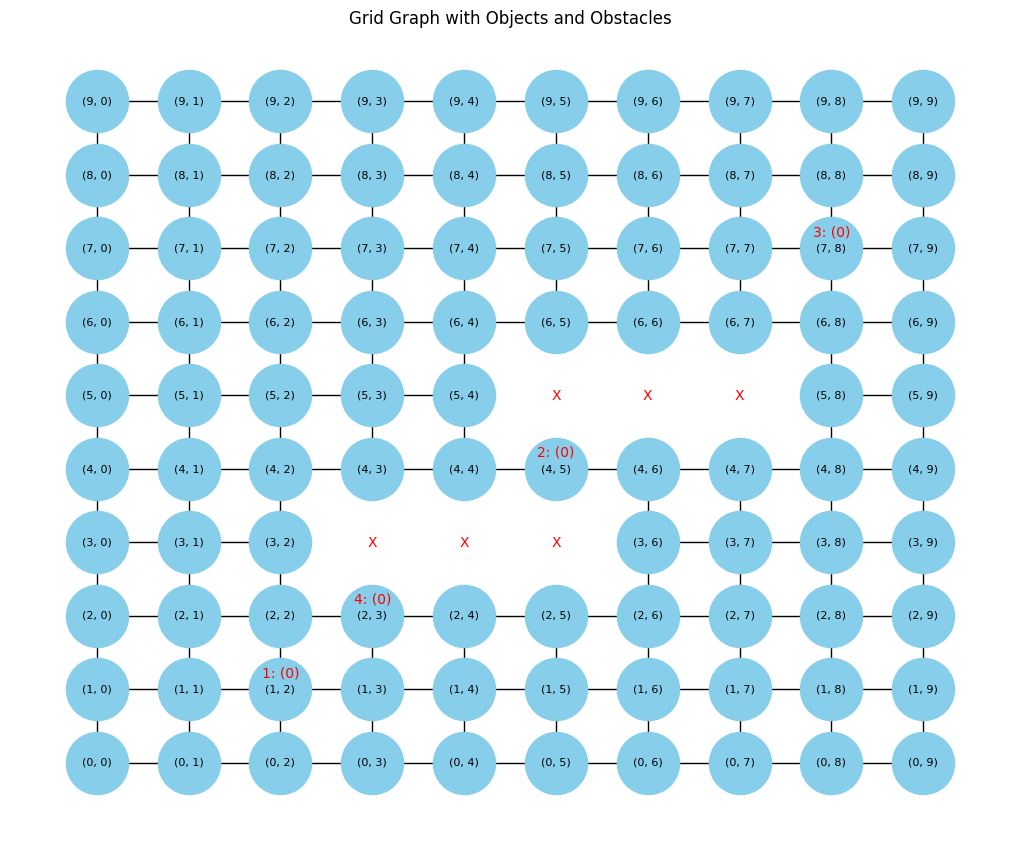

In [10]:
print("Starting position:", starting_position)
print("Miglior percorso:", best_route)
print("Distanza del miglior percorso:", best_distance)

fig = plt.figure(figsize=(10, 8))  # Dimensioni della figura in pollici
pos = {(x, y): (y, -x) for x, y in G.nodes()}  # Invertiamo le coordinate per avere l'orientazione corretta
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=8, font_color='black')

# Aggiungiamo le etichette degli oggetti
for obj, weight in zip(objects, weights):
    plt.text(obj[1], -obj[0], f'{objects.index(obj)+1}: ({weight})\n\n', ha='center', va='center', color='red')

# Aggiungiamo le etichette degli ostacoli
for obstacle in obstacles:
    plt.text(obstacle[1], -obstacle[0], 'X', ha='center', va='center', color='red')

plt.title('Grid Graph with Objects and Obstacles')
plt.gca().invert_yaxis()  # Invertiamo l'asse y per avere l'orientazione corretta
plt.show()
